# Video Anomaly Detection (UCF-Crime)


### Notebook EDA – Exploratory Data Analysis del dataset UCF-Crime

Este notebook corresponde a la **fase de Análisis Exploratorio de Datos (EDA)** del proyecto, cuyo objetivo es comprender, organizar y validar el conjunto de videos antes de las etapas de segmentación temporal y modelado.

En particular, en este notebook se realizó:

- Inspección de la estructura del dataset UCF-Crime y verificación de rutas y carpetas.
- Conteo y validación de videos anómalos por categoría.
- Construcción de un conjunto balanceado de videos a nivel **video** para la tarea de detección binaria (anómalo vs normal).
- Selección de una muestra representativa de videos para **revisión visual exploratoria**, con el fin de analizar contenido, calidad visual y contexto.
- Partición del conjunto balanceado en **subconjuntos de entrenamiento, validación y prueba**, estratificados según la etiqueta binaria.

Como resultado de este análisis, se generaron y almacenaron los siguientes artefactos:

- **Índice de videos balanceado (5 categorías anómalas)**  
  Ubicación: `processed/index_videos_balanced_5cats.csv`  
  Contiene la lista de videos anómalos y normales etiquetados de forma binaria (`y ∈ {0,1}`).

- **Índices de partición Train / Validation / Test**  
  Ubicación:  
  - `processed/index_videos_train.csv`  
  - `processed/index_videos_val.csv`  
  - `processed/index_videos_test.csv`  

  Cada archivo contiene el subconjunto correspondiente del dataset, a nivel de video, manteniendo el balance entre clases.

- **Muestra para revisión visual**  
  Ubicación: `processed/videos_revision_visual.csv`  
  Contiene una selección aleatoria y reproducible de videos anómalos y normales, utilizada exclusivamente para inspección manual y análisis cualitativo.

Este notebook no realiza segmentación temporal en clips ni entrenamiento de modelos. Su propósito es **preparar, documentar y validar los datos** que serán utilizados en las fases posteriores de preprocesamiento temporal, extracción de características y evaluación del sistema de detección de anomalías.


# Fase 0 — Setup del proyecto

## Índice
0.1 Imports y configuración base  
0.2 Semilla y reproducibilidad  
0.3 Estructura de proyecto (rutas)  
0.4 Verificación de rutas críticas  
0.5 Descripción de las rutas


## 0.1 Imports y configuración base

Se importan librerías estándar y científicas para:
- rutas y sistema (os, pathlib)
- reproducibilidad (random, numpy)
- tabulares (pandas)
- utilidades (json, gc)


In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

In [2]:
print("PID:", os.getpid())
print("CWD:", os.getcwd())

PID: 1161930
CWD: /home/DIINF/dvaldes/tesis


## 0.2 Semilla y reproducibilidad

Se fija una semilla global para que los muestreos y procesos sean reproducibles.


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("SEED:", SEED)


SEED: 42


## 0.3 Estructura de proyecto (rutas)

Se definen rutas canónicas:
- PROJECT_ROOT: raíz del proyecto
- DATASET_ROOT: dataset UCF-Crime
- PROCESSED_DIR: índices y salidas intermedias (CSV)
- ARTIFACTS_DIR: resultados por experimento


In [4]:
PROJECT_ROOT = Path(
    os.environ.get("TESIS_ROOT", Path.cwd())
).resolve()

DATASET_ROOT  = PROJECT_ROOT / "UCF_Crime"
PROCESSED_DIR = PROJECT_ROOT / "processed"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

for p in [PROCESSED_DIR, ARTIFACTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)



## 0.4 Verificación de rutas críticas

Se valida que las rutas requeridas existan antes de continuar.


In [5]:
def assert_exists(path: Path, name: str):
    if not path.exists():
        raise FileNotFoundError(f"No existe {name}: {path}")

assert_exists(PROJECT_ROOT, "PROJECT_ROOT")
assert_exists(DATASET_ROOT, "DATASET_ROOT")
assert_exists(PROCESSED_DIR, "PROCESSED_DIR")
assert_exists(ARTIFACTS_DIR, "ARTIFACTS_DIR")

print("Rutas principales verificadas.")


Rutas principales verificadas.


## 0.5 Descripción de las rutas del proyecto

- **PROJECT_ROOT**: contiene todo el proyecto de la memoria, incluyendo código, documentación, y las carpetas de datos procesados y resultados experimentales.

- **DATASET_ROOT**: almacena el dataset UCF-Crime en su estructura original y sin modificaciones, siendo la fuente primaria de los datos de entrada.

- **PROCESSED_DIR**: guarda todos los datos intermedios derivados del dataset original, como índices, splits y tablas de análisis, actuando como fuente única de verdad para la reproducibilidad.

- **ARTIFACTS_DIR**: contiene los resultados finales de los experimentos, incluyendo modelos entrenados, configuraciones y métricas de evaluación.


# Fase 1 — Perfilado del dataset (UCF-Crime)

## Índice
1.1 Definición de carpetas normales y anomalías  
1.2 Conteo de anomalías por categoría (dataset completo)  
1.3 Conteo de normales (dataset completo)  
1.4 Resumen global y export de conteos  
1.5 Duración promedio por categoría (anomalías) y duración promedio de normales (global)  
1.6 Etiquetar datset y muestrear  
 1.7 Selección visual de la muestra (Percentiles) 
   
1.8 Selección de muestra para revisión visual



## 1.1 Definición de carpetas

UCF-Crime distribuye anomalías en 4 partes (Anomaly-Videos-Part-1..4) y normales en carpetas separadas.


In [6]:
ANOMALY_ROOT_FOLDERS = [
    "Anomaly-Videos-Part-1",
    "Anomaly-Videos-Part-2",
    "Anomaly-Videos-Part-3",
    "Anomaly-Videos-Part-4",
]

NORMAL_FOLDERS = [
    "Training-Normal-Videos-Part-1",
    "Training-Normal-Videos-Part-2",
    "Testing_Normal_Videos_Anomaly",
]


## 1.2 Conteo de anomalías por categoría

Se recorren todas las carpetas de anomalías y se contabilizan los videos por categoría (subcarpeta).


In [7]:
anomaly_counts = defaultdict(int)

for part in ANOMALY_ROOT_FOLDERS:
    part_path = DATASET_ROOT / part
    if not part_path.exists():
        continue

    for category_dir in part_path.iterdir():
        if not category_dir.is_dir():
            continue

        mp4s = list(category_dir.glob("*.mp4"))
        anomaly_counts[category_dir.name] += len(mp4s)

total_anomaly_videos = sum(anomaly_counts.values())

print("Anomalías por categoría:")
for cat, count in sorted(anomaly_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cat:20s} {count}")

print("Total videos anómalos:", total_anomaly_videos)



Anomalías por categoría:
Robbery              150
RoadAccidents        150
Burglary             100
Stealing             100
Abuse                50
Assault              50
Arrest               50
Arson                50
Fighting             50
Explosion            50
Shooting             50
Vandalism            50
Shoplifting          50
Total videos anómalos: 950


## 1.3 Conteo de normales

Se contabilizan los videos normales en las carpetas de normales definidas.


In [8]:
normal_counts = {}
total_normals = 0

for rel_folder in NORMAL_FOLDERS:
    folder = DATASET_ROOT / rel_folder
    if not folder.exists():
        print(f"[WARN] No existe la carpeta: {rel_folder}")
        continue

    mp4s = list(folder.rglob("*.mp4"))
    count = len(mp4s)

    normal_counts[rel_folder] = count
    total_normals += count

    print(f"{rel_folder}: {count}")

print("Total videos normales:", total_normals)



Training-Normal-Videos-Part-1: 432
Training-Normal-Videos-Part-2: 370
Testing_Normal_Videos_Anomaly: 150
Total videos normales: 952


## 1.4 Resumen global y export

Se genera una tabla con el conteo de anomalías por categoría y se exporta a CSV.


In [9]:
normal_train_count = 0
normal_test_count = 0

for rel_folder, count in normal_counts.items():
    if "Training" in rel_folder:
        normal_train_count += count
    else:
        normal_test_count += count

total_normals = normal_train_count + normal_test_count
total_videos = total_anomaly_videos + total_normals

print("Resumen global del dataset:")
print("Total videos               :", total_videos)
print("Videos anómalos             :", total_anomaly_videos)
print("Videos normales (total)     :", total_normals)
print("Videos normales (training)  :", normal_train_count)
print("Videos normales (testing)   :", normal_test_count)



Resumen global del dataset:
Total videos               : 1902
Videos anómalos             : 950
Videos normales (total)     : 952
Videos normales (training)  : 802
Videos normales (testing)   : 150


## 1.5  Análisis temporal de los videos

 - Duración promedio de videos normales - segundos 
 - Duración promedio por categoría (anomalías) - segundos 




La duración de ada video se estima a partir de sus metadatos:
duración (segundos) = número de frames / FPS.

In [10]:
def video_duration_seconds(video_path: Path) -> float:
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        cap.release()
        return np.nan

    fps = cap.get(cv2.CAP_PROP_FPS)
    n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()

    if fps is None or fps <= 0 or n_frames is None or n_frames <= 0:
        return np.nan

    return float(n_frames) / float(fps)


In [11]:
MAX_VIDEOS_PER_CATEGORY = None  # None = usar todos

rows = []

def process_videos(category, folders):
    durations = []  # (duracion_s, video_name, carpeta)

    for folder_rel in folders:
        folder = DATASET_ROOT / folder_rel
        if not folder.exists():
            continue

        mp4s = list(folder.glob("*.mp4")) if "*" not in folder_rel else list(folder.rglob("*.mp4"))
        if MAX_VIDEOS_PER_CATEGORY is not None:
            mp4s = mp4s[:MAX_VIDEOS_PER_CATEGORY]

        for vp in mp4s:
            d = video_duration_seconds(vp)
            if np.isfinite(d):
                durations.append((d, vp.name, folder_rel))

    if len(durations) == 0:
        return {
            "categoria": category,
            "n_videos": 0,
            "duracion_media_s": np.nan,
            "duracion_min_s": np.nan,
            "video_mas_corto": None,
            "carpeta_video_mas_corto": None,
            "duracion_max_s": np.nan,
            "video_mas_largo": None,
            "carpeta_video_mas_largo": None,
        }

    durations.sort(key=lambda x: x[0])
    arr = np.array([d[0] for d in durations], dtype=np.float32)

    return {
        "categoria": category,
        "n_videos": int(arr.size),
        "duracion_media_s": float(arr.mean()),
        "duracion_min_s": float(durations[0][0]),
        "video_mas_corto": durations[0][1],
        "carpeta_video_mas_corto": durations[0][2],
        "duracion_max_s": float(durations[-1][0]),
        "video_mas_largo": durations[-1][1],
        "carpeta_video_mas_largo": durations[-1][2],
    }


# =========================
# Anomalías
# =========================
anomaly_categories = set()
for part in ANOMALY_ROOT_FOLDERS:
    part_path = DATASET_ROOT / part
    if part_path.exists():
        for d in part_path.iterdir():
            if d.is_dir():
                anomaly_categories.add(d.name)

for cat in sorted(anomaly_categories):
    folders = [f"{part}/{cat}" for part in ANOMALY_ROOT_FOLDERS]
    rows.append(process_videos(cat, folders))


# =========================
# Normal
# =========================
rows.append(process_videos("Normal", NORMAL_FOLDERS))


# =========================
# DataFrame final
# =========================
df_durations = (
    pd.DataFrame(rows)
    .sort_values("duracion_media_s", ascending=False)
    .reset_index(drop=True)
)

df_durations


,categoria,n_videos,duracion_media_s,duracion_min_s,video_mas_corto,carpeta_video_mas_corto,duracion_max_s,video_mas_largo,carpeta_video_mas_largo
0,Normal,950,355.286224,6.766667,Normal_Videos157_x264.mp4,Training-Normal-Videos-Part-1,32550.100000,Normal_Videos308_x264.mp4,Training-Normal-Videos-Part-1
1,Shoplifting,50,216.244675,14.900000,Shoplifting031_x264.mp4,Anomaly-Videos-Part-4/Shoplifting,2223.266667,Shoplifting014_x264.mp4,Anomaly-Videos-Part-4/Shoplifting
2,Arrest,50,198.268066,32.533333,Arrest015_x264.mp4,Anomaly-Videos-Part-1/Arrest,2102.000000,Arrest047_x264.mp4,Anomaly-Videos-Part-1/Arrest
3,Arson,50,181.268677,12.866667,Arson049_x264.mp4,Anomaly-Videos-Part-1/Arson,4218.433333,Arson019_x264.mp4,Anomaly-Videos-Part-1/Arson
4,Fighting,50,172.596680,26.766667,Fighting038_x264.mp4,Anomaly-Videos-Part-2/Fighting,1054.733333,Fighting041_x264.mp4,Anomaly-Videos-Part-2/Fighting
5,Explosion,50,168.269333,9.200000,Explosion050_x264.mp4,Anomaly-Videos-Part-2/Explosion,4730.000000,Explosion046_x264.mp4,Anomaly-Videos-Part-2/Explosion
6,Burglary,100,157.068665,10.000000,Burglary097_x264.mp4,Anomaly-Videos-Part-2/Burglary,1620.800000,Burglary064_x264.mp4,Anomaly-Videos-Part-2/Burglary
7,Stealing,100,155.805328,13.533333,Stealing029_x264.mp4,Anomaly-Videos-Part-4/Stealing,727.166667,Stealing025_x264.mp4,Anomaly-Videos-Part-4/Stealing
8,Abuse,50,128.998001,10.000000,Abuse029_x264.mp4,Anomaly-Videos-Part-1/Abuse,949.200000,Abuse042_x264.mp4,Anomaly-Videos-Part-1/Abuse
9,Shooting,50,98.315338,8.433333,Shooting001_x264.mp4,Anomaly-Videos-Part-3/Shooting,722.700000,Shooting032_x264.mp4,Anomaly-Videos-Part-3/Shooting


## 1.5.1  Análisis temporal de los videos por las 5 categorías


In [12]:
MAX_VIDEOS_PER_CATEGORY = None 

TARGET_CATEGORIES = [
    "Robbery",
    "Assault",
    "Vandalism",
    "Abuse",
    "Fighting",
]

anomaly_rows_s = []

for cat in TARGET_CATEGORIES:
    durations = []  
    for part in ANOMALY_ROOT_FOLDERS:
        cat_dir = DATASET_ROOT / part / cat
        if not cat_dir.exists():
            continue

        mp4s = list(cat_dir.glob("*.mp4"))
        if MAX_VIDEOS_PER_CATEGORY is not None:
            mp4s = mp4s[:MAX_VIDEOS_PER_CATEGORY]

        for vp in mp4s:
            d = video_duration_seconds(vp)
            if np.isfinite(d):
                durations.append((d, vp.name, part))

    if len(durations) == 0:
        anomaly_rows_s.append({
            "categoria": cat,
            "n_videos": 0,
            "duracion_media_s": np.nan,
            "duracion_min_s": np.nan,
            "video_mas_corto": None,
            "carpeta_video_mas_corto": None,
            "duracion_max_s": np.nan,
            "video_mas_largo": None,
            "carpeta_video_mas_largo": None,
        })
        continue

    durations.sort(key=lambda x: x[0])
    arr = np.array([d[0] for d in durations], dtype=np.float32)

    anomaly_rows_s.append({
        "categoria": cat,
        "n_videos": int(arr.size),
        "duracion_media_s": float(arr.mean()),
        "duracion_min_s": float(durations[0][0]),
        "video_mas_corto": durations[0][1],
        "carpeta_video_mas_corto": durations[0][2],
        "duracion_max_s": float(durations[-1][0]),
        "video_mas_largo": durations[-1][1],
        "carpeta_video_mas_largo": durations[-1][2],
    })

df_anom_s_5cats = (
    pd.DataFrame(anomaly_rows_s)
    .sort_values("duracion_media_s", ascending=False)
    .reset_index(drop=True)
)

df_anom_s_5cats


,categoria,n_videos,duracion_media_s,duracion_min_s,video_mas_corto,carpeta_video_mas_corto,duracion_max_s,video_mas_largo,carpeta_video_mas_largo
0,Fighting,50,172.596680,26.766667,Fighting038_x264.mp4,Anomaly-Videos-Part-2,1054.733333,Fighting041_x264.mp4,Anomaly-Videos-Part-2
1,Abuse,50,128.998001,10.000000,Abuse029_x264.mp4,Anomaly-Videos-Part-1,949.200000,Abuse042_x264.mp4,Anomaly-Videos-Part-1
2,Vandalism,50,98.108002,14.300000,Vandalism014_x264.mp4,Anomaly-Videos-Part-4,419.633333,Vandalism008_x264.mp4,Anomaly-Videos-Part-4
3,Robbery,150,93.909775,9.066667,Robbery089_x264.mp4,Anomaly-Videos-Part-3,509.266667,Robbery014_x264.mp4,Anomaly-Videos-Part-3
4,Assault,50,86.630676,4.566667,Assault038_x264.mp4,Anomaly-Videos-Part-1,539.233333,Assault010_x264.mp4,Anomaly-Videos-Part-1


## 1.6 Etiquetar datset y muestrear

- Se seleccionaron cinco categorías críticas de anomalía del dataset UCF-Crime: Robbery, Assault, Vandalism, Abuse y Fighting.

- Todos los videos pertenecientes a estas categorías fueron etiquetados como clase positiva (`y = 1`), independientemente de su categoría específica, dado que la tarea abordada es de detección binaria de anomalías.

- Los videos normales, originalmente superiores en cantidad, fueron submuestreados de manera aleatoria y reproducible para igualar el número total de videos anómalos, construyendo así un conjunto balanceado a nivel de videos.

- El muestreo de videos normales se realizó utilizando una semilla fija, asegurando la reproducibilidad de los experimentos.

- El conjunto balanceado resultante se estableció como base para la posterior generación de clips temporales y para la división en subconjuntos de entrenamiento, validación y prueba.


## 1.6.1  Etiquetar {1} videos por las 5 categorías


In [13]:
TARGET_CATEGORIES = ["Robbery", "Assault", "Vandalism", "Abuse", "Fighting"]


In [14]:

anom_records = []

for cat in TARGET_CATEGORIES:
    for part in ANOMALY_ROOT_FOLDERS:
        cat_dir = DATASET_ROOT / part / cat
        if not cat_dir.exists():
            continue

        for vp in cat_dir.glob("*.mp4"):
            anom_records.append({
                "path_abs": str(vp.resolve()),
                "path_rel": str(vp.relative_to(DATASET_ROOT)),
                "y": 1,
                "categoria": cat,
                "source_folder": f"{part}/{cat}",
            })

df_anom = pd.DataFrame(anom_records).drop_duplicates(subset=["path_abs"]).reset_index(drop=True)

print("Anomalías (5 cats):", len(df_anom))
print(df_anom["categoria"].value_counts())
df_anom.head()


Anomalías (5 cats): 350
categoria
Robbery      150
Assault       50
Vandalism     50
Abuse         50
Fighting      50
Name: count, dtype: int64


,path_abs,path_rel,y,categoria,source_folder
0,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-3/Robbery/Robbery028_x264.mp4,1,Robbery,Anomaly-Videos-Part-3/Robbery
1,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-3/Robbery/Robbery029_x264.mp4,1,Robbery,Anomaly-Videos-Part-3/Robbery
2,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-3/Robbery/Robbery110_x264.mp4,1,Robbery,Anomaly-Videos-Part-3/Robbery
3,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-3/Robbery/Robbery084_x264.mp4,1,Robbery,Anomaly-Videos-Part-3/Robbery
4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-3/Robbery/Robbery064_x264.mp4,1,Robbery,Anomaly-Videos-Part-3/Robbery


## 1.6.2  Etiquetar {0} videos normales


In [15]:
norm_records = []

for rel_folder in NORMAL_FOLDERS:
    folder = DATASET_ROOT / rel_folder
    if not folder.exists():
        continue

    for vp in folder.rglob("*.mp4"):
        norm_records.append({
            "path_abs": str(vp.resolve()),
            "path_rel": str(vp.relative_to(DATASET_ROOT)),
            "y": 0,
            "categoria": "Normal",
            "source_folder": rel_folder,
        })

df_norm_all = pd.DataFrame(norm_records).drop_duplicates(subset=["path_abs"]).reset_index(drop=True)

print("Normales (total):", len(df_norm_all))
df_norm_all.head()


Normales (total): 952


,path_abs,path_rel,y,categoria,source_folder
0,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos457...,0,Normal,Training-Normal-Videos-Part-1
1,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos320...,0,Normal,Training-Normal-Videos-Part-1
2,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos178...,0,Normal,Training-Normal-Videos-Part-1
3,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos088...,0,Normal,Training-Normal-Videos-Part-1
4,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos269...,0,Normal,Training-Normal-Videos-Part-1


## 1.6.3  Muestrear normales de 950 a 350 para balancear clases


In [16]:
N_ANOM = len(df_anom)
if len(df_norm_all) < N_ANOM:
    raise RuntimeError(f"No hay suficientes normales para muestrear {N_ANOM}. Disponibles: {len(df_norm_all)}")

df_norm = df_norm_all.sample(n=N_ANOM, random_state=SEED).reset_index(drop=True)

print("Normales muestreados:", len(df_norm))
df_norm.head()


Normales muestreados: 350


,path_abs,path_rel,y,categoria,source_folder
0,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos341...,0,Normal,Training-Normal-Videos-Part-1
1,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos176...,0,Normal,Training-Normal-Videos-Part-1
2,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-2/Normal_Videos794...,0,Normal,Training-Normal-Videos-Part-2
3,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-2/Normal_Videos751...,0,Normal,Training-Normal-Videos-Part-2
4,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-2/Normal_Videos484...,0,Normal,Training-Normal-Videos-Part-2


In [17]:
df_balanced = pd.concat([df_anom, df_norm], ignore_index=True)

# Mezclar filas (reproducible)
df_balanced = df_balanced.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Total balanceado:", len(df_balanced))
print(df_balanced["y"].value_counts())
df_balanced.head()


Total balanceado: 700
y
1    350
0    350
Name: count, dtype: int64


,path_abs,path_rel,y,categoria,source_folder
0,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-1/Assault/Assault052_x264.mp4,1,Assault,Anomaly-Videos-Part-1/Assault
1,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-2/Normal_Videos695...,0,Normal,Training-Normal-Videos-Part-2
2,/home/DIINF/dvaldes/tesis/UCF_Crime/Training-N...,Training-Normal-Videos-Part-1/Normal_Videos120...,0,Normal,Training-Normal-Videos-Part-1
3,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-1/Assault/Assault038_x264.mp4,1,Assault,Anomaly-Videos-Part-1/Assault
4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...,Anomaly-Videos-Part-2/Fighting/Fighting008_x26...,1,Fighting,Anomaly-Videos-Part-2/Fighting


In [18]:
out_csv = PROCESSED_DIR / "index_videos_balanced_5cats.csv"
df_balanced.to_csv(out_csv, index=False)
print("Guardado en:", out_csv)


Guardado en: /home/DIINF/dvaldes/tesis/processed/index_videos_balanced_5cats.csv


## 1.7  Estadísticas y visualización

In [19]:
def duration_percentiles(durations_s):
    arr = np.array(durations_s, dtype=np.float32)
    return {
        "n_videos": int(arr.size),
        "p25_s": float(np.percentile(arr, 25)),
        "p50_s": float(np.percentile(arr, 50)),
        "p75_s": float(np.percentile(arr, 75)),
        "p90_s": float(np.percentile(arr, 90)),
        "max_s": float(arr.max()),
    }


## 1.7.1 Percentiles de duración de los videos  

In [20]:
rows_anom_dist = []

for cat in TARGET_CATEGORIES:
    durations = []

    for part in ANOMALY_ROOT_FOLDERS:
        cat_dir = DATASET_ROOT / part / cat
        if not cat_dir.exists():
            continue

        for vp in cat_dir.glob("*.mp4"):
            d = video_duration_seconds(vp)
            if np.isfinite(d):
                durations.append(d)

    if len(durations) == 0:
        continue

    stats_raw = duration_percentiles(durations)

    stats = {
        "categoria": cat,
        "n_videos": stats_raw["n_videos"],
        "p25_s": stats_raw["p25_s"],
        "p50_s": stats_raw["p50_s"],
        "p75_s": stats_raw["p75_s"],
        "p90_s": stats_raw["p90_s"],
        "max_s": stats_raw["max_s"],
    }

    rows_anom_dist.append(stats)

df_anom_duration_dist = (
    pd.DataFrame(rows_anom_dist)
    .sort_values("p50_s", ascending=False)
    .reset_index(drop=True)
)

df_anom_duration_dist



,categoria,n_videos,p25_s,p50_s,p75_s,p90_s,max_s
0,Fighting,50,71.691666,117.800003,205.941666,303.113281,1054.733276
1,Abuse,50,48.166664,89.666672,145.933334,180.149857,949.200012
2,Robbery,150,40.391666,65.516663,116.150002,193.399887,509.266663
3,Vandalism,50,38.549999,64.799995,131.391663,195.303314,419.633331
4,Assault,50,26.741667,59.466667,102.158333,221.553314,539.233337


In [21]:
normal_durations = []

for vp in df_norm["path_abs"]:
    d = video_duration_seconds(Path(vp))
    if np.isfinite(d):
        normal_durations.append(d)

df_norm_duration_dist = pd.DataFrame([{
    "categoria": "Normal",
    **duration_percentiles(normal_durations)
}])

df_norm_duration_dist



,categoria,n_videos,p25_s,p50_s,p75_s,p90_s,max_s
0,Normal,350,39.983334,74.766663,178.975006,608.116699,32550.099609


In [22]:
df_duration_distribution = pd.concat(
    [df_anom_duration_dist, df_norm_duration_dist],
    ignore_index=True
)

df_duration_distribution


,categoria,n_videos,p25_s,p50_s,p75_s,p90_s,max_s
0,Fighting,50,71.691666,117.800003,205.941666,303.113281,1054.733276
1,Abuse,50,48.166664,89.666672,145.933334,180.149857,949.200012
2,Robbery,150,40.391666,65.516663,116.150002,193.399887,509.266663
3,Vandalism,50,38.549999,64.799995,131.391663,195.303314,419.633331
4,Assault,50,26.741667,59.466667,102.158333,221.553314,539.233337
5,Normal,350,39.983334,74.766663,178.975006,608.116699,32550.099609


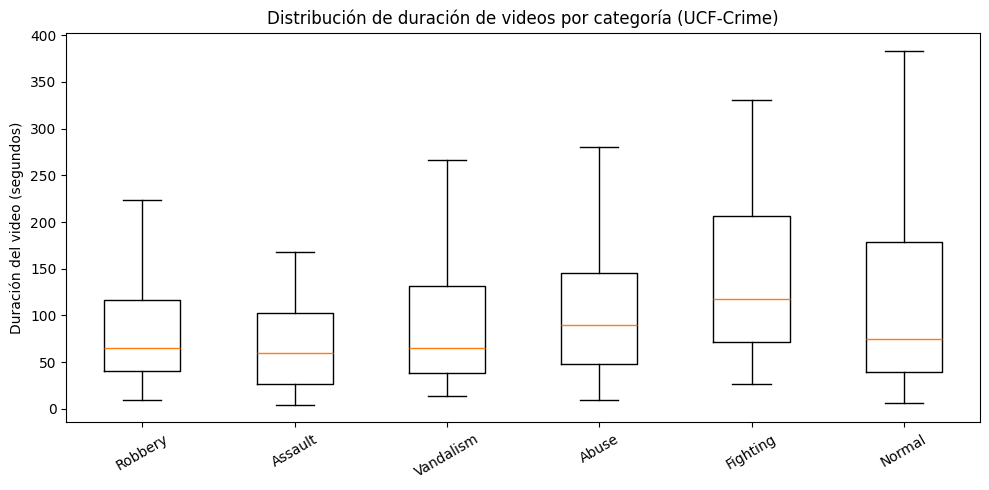

In [23]:
duration_by_cat = {}

# Anómalos
for cat in TARGET_CATEGORIES:
    durations = []

    for part in ANOMALY_ROOT_FOLDERS:
        cat_dir = DATASET_ROOT / part / cat
        if not cat_dir.exists():
            continue

        for vp in cat_dir.glob("*.mp4"):
            d = video_duration_seconds(vp)
            if np.isfinite(d):
                durations.append(d)

    if len(durations) > 0:
        duration_by_cat[cat] = durations

# Normales
duration_by_cat["Normal"] = normal_durations

# Orden
ordered_cats = TARGET_CATEGORIES + ["Normal"]
data = [duration_by_cat[c] for c in ordered_cats]

# Plot
plt.figure(figsize=(10, 5))
plt.boxplot(
    data,
    vert=True,
    showfliers=False  # saca outliers extremos para que se lea mejor
)

plt.xticks(range(1, len(ordered_cats) + 1), ordered_cats, rotation=30)
plt.ylabel("Duración del video (segundos)")
plt.title("Distribución de duración de videos por categoría (UCF-Crime)")

plt.tight_layout()
plt.show()


## 1.7.2 Percentiles de duración de los videos por puntos
La Figura muestra la distribución de la duración de los videos por categoría en el conjunto UCF-Crime, visualizada mediante boxplots con los valores individuales superpuestos y una escala logarítmica en el eje vertical. Esta representación permite observar simultáneamente la masa central de los datos y la presencia de colas largas, especialmente en la clase Normal.

Las líneas horizontales punteadas indican los percentiles globales de duración (p25, p50, p75 y p90). Se observa que la mayoría de los videos se concentra entre p25 y p75, con una mediana (p50 ≈ 74 s) representativa del video típico del conjunto. A partir de p90 (≈ 318 s) comienza una cola de videos considerablemente más largos, lo que evidencia una alta heterogeneidad temporal y la existencia de valores atípicos de gran magnitud.

In [24]:
all_durations = np.concatenate(data)

p25, p50, p75, p90 = np.percentile(all_durations, [25, 50, 75, 90])

print(f"p25={p25:.1f}s, p50={p50:.1f}s, p75={p75:.1f}s, p90={p90:.1f}s")


p25=39.9s, p50=74.4s, p75=145.3s, p90=318.4s


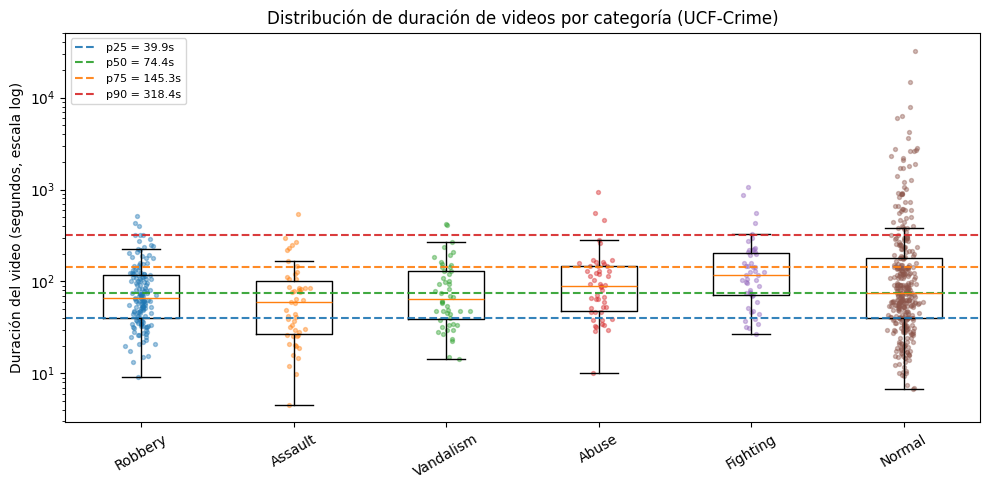

In [25]:
plt.figure(figsize=(10, 5))

# Boxplot
plt.boxplot(
    data,
    vert=True,
    showfliers=False
)

# Puntos
for i, durs in enumerate(data, start=1):
    x = np.random.normal(i, 0.04, size=len(durs))
    plt.scatter(x, durs, s=8, alpha=0.4)

# Percentiles globales
all_durations = np.concatenate(data)
p25, p50, p75, p90 = np.percentile(all_durations, [25, 50, 75, 90])

percentiles = {
    "p25": (p25, "tab:blue"),
    "p50": (p50, "tab:green"),
    "p75": (p75, "tab:orange"),
    "p90": (p90, "tab:red"),
}

for label, (p, color) in percentiles.items():
    plt.axhline(
        y=p,
        color=color,
        linestyle="--",
        linewidth=1.5,
        alpha=0.9,
        label=f"{label} = {p:.1f}s"
    )

# Escala log
plt.yscale("log")

plt.xticks(range(1, len(ordered_cats) + 1), ordered_cats, rotation=30)
plt.ylabel("Duración del video (segundos, escala log)")
plt.title("Distribución de duración de videos por categoría (UCF-Crime)")
plt.legend(loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()


## 1.7.3  Resumen de Percentiles de duración de los videos de los 700 videos

In [26]:
balanced_durations = []

for vp in df_balanced["path_abs"]:
    d = video_duration_seconds(Path(vp))
    if np.isfinite(d):
        balanced_durations.append(d)

df_balanced_duration_dist = pd.DataFrame([{
    "categoria": "Balanced_All",
    **duration_percentiles(balanced_durations)
}])

df_balanced_duration_dist


,categoria,n_videos,p25_s,p50_s,p75_s,p90_s,max_s
0,Balanced_All,700,39.925003,74.433334,145.266663,318.373322,32550.099609


# 1.8 Selección de muestra para revisión visual

Previo a la segmentación temporal y al entrenamiento del modelo, se seleccionó una muestra representativa del conjunto de datos con el objetivo de realizar una **revisión visual exploratoria** de los videos.

A partir del dataset balanceado (`df_balanced`), se extrajo de manera aleatoria y reproducible una muestra compuesta por:
- **5 videos por cada una de las cinco categorías anómalas** (robo, asalto, vandalismo, maltrato y peleas).
- **25 videos normales**.

La muestra fue ordenada por categoría y exportada a un archivo CSV, permitiendo inspeccionar manualmente el contenido, la calidad visual y el contexto de los eventos. Este análisis cualitativo respalda las decisiones posteriores de preprocesamiento y segmentación mediante ventanas deslizantes, manteniendo la formulación del problema como una tarea de **detección binaria de anomalías**.


In [27]:
N_PER_CAT_ANOM = 5
N_NORMAL = 25

# 1) Pool anómalos (solo 5 categorías)
df_anom_pool = df_balanced[(df_balanced["y"] == 1) & (df_balanced["categoria"].isin(TARGET_CATEGORIES))].copy()

# 2) Pool normales
df_norm_pool = df_balanced[df_balanced["y"] == 0].copy()

print("Anómalos disponibles (5 cats):", len(df_anom_pool))
print("Normales disponibles:", len(df_norm_pool))
print("\nAnómalos por categoría:")
print(df_anom_pool["categoria"].value_counts())

# 3) Sample: 5 por categoría (anom)
samples_anom = []
for cat in TARGET_CATEGORIES:
    g = df_anom_pool[df_anom_pool["categoria"] == cat]
    if len(g) < N_PER_CAT_ANOM:
        raise RuntimeError(f"No hay suficientes videos para {cat}. Requeridos {N_PER_CAT_ANOM}, disponibles {len(g)}")
    samples_anom.append(g.sample(n=N_PER_CAT_ANOM, random_state=SEED))

df_anom_review = pd.concat(samples_anom, ignore_index=True)

# 4) Sample: 25 normales
if len(df_norm_pool) < N_NORMAL:
    raise RuntimeError(f"No hay suficientes normales. Requeridos {N_NORMAL}, disponibles {len(df_norm_pool)}")

df_norm_review = df_norm_pool.sample(n=N_NORMAL, random_state=SEED).reset_index(drop=True)

# 5) Unión final (revisión)
df_review = pd.concat([df_anom_review, df_norm_review], ignore_index=True)
df_review = df_review.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

# Nombre de video 
if "path_rel" in df_review.columns:
    df_review["video_name"] = df_review["path_rel"].astype(str).apply(lambda p: Path(p).name)
else:
    df_review["video_name"] = df_review["path_abs"].astype(str).apply(lambda p: Path(p).name)

print("\nMuestra final para revisión:", len(df_review))
print("Conteo y:")
print(df_review["y"].value_counts())

# Mostrar tabla con lo que te interesa
cols = ["video_name", "categoria", "y", "source_folder", "path_rel", "path_abs"]
cols = [c for c in cols if c in df_review.columns]

# Ordenar la tabla por categoría
df_review = df_review.sort_values(
    by=["y", "categoria", "video_name"],
    ascending=[False, True, True]
).reset_index(drop=True)

display(df_review[cols])

# Ruta de salida
out_csv = PROCESSED_DIR / "videos_revision_visual.csv"

# Exportar
df_review.to_csv(out_csv, index=False)

print("CSV exportado en:")
print(out_csv)



Anómalos disponibles (5 cats): 350
Normales disponibles: 350

Anómalos por categoría:
categoria
Robbery      150
Assault       50
Fighting      50
Vandalism     50
Abuse         50
Name: count, dtype: int64

Muestra final para revisión: 50
Conteo y:
y
1    25
0    25
Name: count, dtype: int64


,video_name,categoria,y,source_folder,path_rel,path_abs
0,Abuse007_x264.mp4,Abuse,1,Anomaly-Videos-Part-1/Abuse,Anomaly-Videos-Part-1/Abuse/Abuse007_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
1,Abuse015_x264.mp4,Abuse,1,Anomaly-Videos-Part-1/Abuse,Anomaly-Videos-Part-1/Abuse/Abuse015_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
2,Abuse027_x264.mp4,Abuse,1,Anomaly-Videos-Part-1/Abuse,Anomaly-Videos-Part-1/Abuse/Abuse027_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
3,Abuse030_x264.mp4,Abuse,1,Anomaly-Videos-Part-1/Abuse,Anomaly-Videos-Part-1/Abuse/Abuse030_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
4,Abuse031_x264.mp4,Abuse,1,Anomaly-Videos-Part-1/Abuse,Anomaly-Videos-Part-1/Abuse/Abuse031_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
5,Assault014_x264.mp4,Assault,1,Anomaly-Videos-Part-1/Assault,Anomaly-Videos-Part-1/Assault/Assault014_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
6,Assault026_x264.mp4,Assault,1,Anomaly-Videos-Part-1/Assault,Anomaly-Videos-Part-1/Assault/Assault026_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
7,Assault029_x264.mp4,Assault,1,Anomaly-Videos-Part-1/Assault,Anomaly-Videos-Part-1/Assault/Assault029_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
8,Assault030_x264.mp4,Assault,1,Anomaly-Videos-Part-1/Assault,Anomaly-Videos-Part-1/Assault/Assault030_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...
9,Assault037_x264.mp4,Assault,1,Anomaly-Videos-Part-1/Assault,Anomaly-Videos-Part-1/Assault/Assault037_x264.mp4,/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Vi...


CSV exportado en:
/home/DIINF/dvaldes/tesis/processed/videos_revision_visual.csv


### Fase 2 – Construcción y partición del dataset (Train / Val / Test)

En esta etapa se consolida un conjunto de datos balanceado a nivel de video para la tarea de **detección binaria de anomalías** (anómalo vs normal).  
El dataset se compone de videos anómalos pertenecientes a cinco categorías críticas (robo, asalto, vandalismo, maltrato y peleas) y videos normales, todos etiquetados con una variable binaria `y ∈ {0,1}`.

A partir del conjunto balanceado, se realiza una **partición estratificada por clase binaria (`y`)** en tres subconjuntos:
- **Train**: 70 % (490 videos)
- **Validation**: 15 % (104 videos)
- **Test**: 15 % (106 videos)

La estratificación asegura una distribución equitativa entre clases normales y anómalas en cada subconjunto.  
Adicionalmente, se verifica de manera exploratoria que las cinco categorías de anomalía se mantengan representadas en los tres splits, sin que estas influyan en la definición del problema, que permanece estrictamente binario.


In [28]:
def split_train_val_test_binary(df, y_col="y", train_frac=0.70, val_frac=0.15, test_frac=0.15, seed=42):
    if not np.isclose(train_frac + val_frac + test_frac, 1.0):
        raise ValueError("train_frac + val_frac + test_frac debe sumar 1.0")

    parts = []
    for yval, g in df.groupby(y_col):
        g = g.sample(frac=1.0, random_state=seed).reset_index(drop=True)

        n = len(g)
        n_train = int(round(n * train_frac))
        n_val = int(round(n * val_frac))
        n_test = n - n_train - n_val

        g_train = g.iloc[:n_train].copy()
        g_val   = g.iloc[n_train:n_train + n_val].copy()
        g_test  = g.iloc[n_train + n_val:].copy()

        g_train["split"] = "train"
        g_val["split"] = "val"
        g_test["split"] = "test"

        parts.append(g_train)
        parts.append(g_val)
        parts.append(g_test)

    out = pd.concat(parts, ignore_index=True)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

df_split = split_train_val_test_binary(
    df_balanced,
    y_col="y",
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    seed=SEED
)

train_df = df_split[df_split["split"] == "train"].reset_index(drop=True)
val_df   = df_split[df_split["split"] == "val"].reset_index(drop=True)
test_df  = df_split[df_split["split"] == "test"].reset_index(drop=True)

print("Total:", len(df_split))
print("Train/Val/Test:", len(train_df), len(val_df), len(test_df))
print("\nConteo por split (binario):")
print(pd.crosstab(df_split["split"], df_split["y"]))


if "categoria" in df_split.columns:
    print("\nChequeo categorias dentro de anómalos (y=1) por split:")
    display(pd.crosstab(df_split[df_split["y"] == 1]["split"], df_split[df_split["y"] == 1]["categoria"]))


Total: 700
Train/Val/Test: 490 104 106

Conteo por split (binario):
y        0    1
split          
test    53   53
train  245  245
val     52   52

Chequeo categorias dentro de anómalos (y=1) por split:


categoria,Abuse,Assault,Fighting,Robbery,Vandalism
split,,,,,
test,8,4,9,28,4
train,35,39,36,98,37
val,7,7,5,24,9


In [29]:
out_train = PROCESSED_DIR / "index_videos_train.csv"
out_val   = PROCESSED_DIR / "index_videos_val.csv"
out_test  = PROCESSED_DIR / "index_videos_test.csv"

train_df.to_csv(out_train, index=False)
val_df.to_csv(out_val, index=False)
test_df.to_csv(out_test, index=False)

print(out_train)
print(out_val)
print(out_test)


/home/DIINF/dvaldes/tesis/processed/index_videos_train.csv
/home/DIINF/dvaldes/tesis/processed/index_videos_val.csv
/home/DIINF/dvaldes/tesis/processed/index_videos_test.csv
